In [ ]:
!pip install -U transformers peft accelerate datasets trl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 kB 42.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 18.1.0
    Uninstalling pyarrow-18.1.0:
      Successfully uninstalled pyarrow-18.1.0
  Attempting uninstall: datasets
    Found existing installation: datasets 4.0.0
    Uninstalling datasets-4.0.0:
      Successfully uninstalled datasets-4.0.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pylibcudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incompatible.
cudf-cu12 25.6.0 requires pyarrow<20.0.0a0,>=14.0.0; platform_machine == "x86_64", but you have pyarrow 22.0.0 which is incomp

In [ ]:
# import
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel, LoraConfig, get_peft_model
from trl import DPOTrainer, DPOConfig
from datasets import load_dataset
import pandas as pd
import json
import gc

print(f"PyTorch: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'None'}")

PyTorch: 2.8.0+cu126
CUDA 사용 가능: True
GPU: NVIDIA A100-SXM4-80GB


In [ ]:
# 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

print("드라이브 마운트 완료!")

Mounted at /content/drive
드라이브 마운트 완료!


In [ ]:
# DPO 데이터 로드

from datasets import load_dataset

# 변환된 DPO 데이터셋 로드
dpo_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo_final_dataset_modified.jsonl'

print("DPO 데이터셋 로드 중...")
dataset = load_dataset("json", data_files=dpo_path)
train_dataset = dataset['train']

print(f"DPO 데이터셋 로드 완료: {len(train_dataset)}개\n")

# 데이터 구조 확인
print("=" * 80)
print("데이터셋 구조 확인")
print("=" * 80)
print(f"\nColumns: {train_dataset.column_names}\n")

# 첫 번째 샘플 출력
print("=" * 80)
print("첫 번째 샘플")
print("=" * 80)
example = train_dataset[0]

print("\n Prompt:")
for msg in example['prompt']:
    print(f"  [{msg['role']}]: {msg['content'][:100]}{'...' if len(msg['content']) > 100 else ''}")

print("\n Chosen:")
for msg in example['chosen']:
    print(f"  [{msg['role']}]: {msg['content']}")

print("\n Rejected:")
for msg in example['rejected']:
    print(f"  [{msg['role']}]: {msg['content']}")

print("\n" + "=" * 80)
print("데이터셋 샘플 추가 확인")
print("=" * 80)

# 두 번째와 세 번째 샘플도 간단히 확인
for i in [1, 2]:
    example = train_dataset[i]
    user_msg = [m for m in example['prompt'] if m['role'] == 'user'][0]['content']
    print(f"\n샘플 {i+1}:")
    print(f"  User: {user_msg[:80]}{'...' if len(user_msg) > 80 else ''}")
    print(f"  Chosen: {example['chosen'][0]['content'][:80]}{'...' if len(example['chosen'][0]['content']) > 80 else ''}")
    print(f"  Rejected: {example['rejected'][0]['content'][:80]}{'...' if len(example['rejected'][0]['content']) > 80 else ''}")

print("\n 데이터셋 확인 완료!")

DPO 데이터셋 로드 중...


Generating train split: 0 examples [00:00, ? examples/s]

DPO 데이터셋 로드 완료: 1681개

데이터셋 구조 확인

Columns: ['prompt', 'chosen', 'rejected']

첫 번째 샘플

 Prompt:
  [system]: You are an AI that generates a single, concise clarifying question when a user's query is ambiguous....
  [user]: [NONE|NONE] Is Pensacola sylvestris a multicellular organism in terms of cellularity?

 Chosen:
  [assistant]: <NO_CLARIFYING_QUESTION>

 Rejected:
  [assistant]: <NO_CQ_QUESTION_1>

데이터셋 샘플 추가 확인

샘플 2:
  User: [AO|WHERE] When did call of duty ww2 come out?
  Chosen: Which one: release, release in the North America, release in Australia, or relea...
  Rejected: Which is the source location?

샘플 3:
  User: [EM|UNF] Does Helicotylenchus have Phaseolus galactoides as its host?
  Chosen: What is Helicotylenchus referring to?
  Rejected: Is the subject in the conversation an organism or a species? Please specify the ...

 데이터셋 확인 완료!


In [ ]:
# 모델 로드

import gc
gc.collect()
torch.cuda.empty_cache()

sft_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/checkpoint-best'
base_model_name = "microsoft/Phi-4-mini-reasoning"

print("모델 로드 중...\n")

# Base 모델 로드
print("Base 모델 로드...")
model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)
print("Base 모델 로드 완료")

# SFT LoRA adapter를 두 번 로드 (같은 모델 인스턴스에!)
print("\n SFT LoRA adapter 로드...")
from peft import PeftModel

# 첫 번째: trainable adapter (학습할 것)
model = PeftModel.from_pretrained(
    model,
    sft_path,
    adapter_name="dpo_train",
    is_trainable=True
)
print("'dpo_train' adapter 로드 완료")

# 두 번째: reference adapter (frozen, 비교용)
model.load_adapter(sft_path, adapter_name="dpo_reference")
print("'dpo_reference' adapter 로드 완료")

# Tokenizer 로드
print("\n Tokenizer 로드...")
tokenizer = AutoTokenizer.from_pretrained(sft_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"  # DPO에서는 left padding 권장!
print("Tokenizer 로드 완료")

# 검증
print("\n" + "=" * 80)
print("모델 구성 검증")
print("=" * 80)

def count_trainable(m):
    return sum(p.numel() for p in m.parameters() if p.requires_grad)

print(f"\nAdapters: {list(model.peft_config.keys())}")
print(f"Active adapter: {model.active_adapter}")
print(f"Trainable parameters: {count_trainable(model):,}")
print(f"Model device: {next(model.parameters()).device}")
print(f"Model dtype: {next(model.parameters()).dtype}")

# Adapter별 파라미터 확인
model.set_adapter("dpo_train")
print(f"\n'dpo_train' trainable params: {count_trainable(model):,}")

model.set_adapter("dpo_reference")
print(f"'dpo_reference' trainable params: {count_trainable(model):,}")

model.set_adapter("dpo_train")  # 다시 train으로 전환
print("\n모델 로드 완료!") # DPOTrainer는 'dpo_train'과 'dpo_reference' adapter를 자동으로 전환

모델 로드 중...

Base 모델 로드...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.77G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.90G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Base 모델 로드 완료

 SFT LoRA adapter 로드...
'dpo_train' adapter 로드 완료
'dpo_reference' adapter 로드 완료

 Tokenizer 로드...
Tokenizer 로드 완료

모델 구성 검증

Adapters: ['dpo_train', 'dpo_reference']
Active adapter: dpo_train
Trainable parameters: 3,670,016
Model device: cuda:0
Model dtype: torch.bfloat16

'dpo_train' trainable params: 3,670,016
'dpo_reference' trainable params: 3,670,016

모델 로드 완료!


In [ ]:
# 모델 테스트 (DPO 전)
print("=" * 80)
print("SFT 모델 테스트 (DPO 전)")
print("=" * 80 + "\n")

# System message 정의 (테스트용)
SYSTEM_MESSAGE = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.
If the query is clear and needs no clarification, output: <NO_CLARIFYING_QUESTION>

Output format: One clarifying question (or <NO_CLARIFYING_QUESTION> if not needed)

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification"""

def test_model(query):
    messages = [
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": query}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )
    return generated.strip()

# 테스트 쿼리
test_queries = [
    "[AO|WHERE] When did call of duty ww2 come out?",
    "[NONE|NONE] Who won the world cup as a player and a manager?",
    "[LA|LEX] What is the most common type of type used in printing?",
]

for idx, query in enumerate(test_queries, 1):
    print(f"테스트 {idx}/{len(test_queries)}")
    print(f"{'─'*80}")
    print(f"Query: {query}\n")
    response = test_model(query)
    print(f"Response: {response}\n")
    print(f"{'─'*80}\n")

print("테스트 완료!")

SFT 모델 테스트 (DPO 전)

테스트 1/3
────────────────────────────────────────────────────────────────────────────────
Query: [AO|WHERE] When did call of duty ww2 come out?

Response: What is the release date of the game Call of Duty: World War II?

────────────────────────────────────────────────────────────────────────────────

테스트 2/3
────────────────────────────────────────────────────────────────────────────────
Query: [NONE|NONE] Who won the world cup as a player and a manager?

Response: <NO_CLARIFYING_QUESTION>

────────────────────────────────────────────────────────────────────────────────

테스트 3/3
────────────────────────────────────────────────────────────────────────────────
Query: [LA|LEX] What is the most common type of type used in printing?

Response: Which type: the most common type or the least common type?

────────────────────────────────────────────────────────────────────────────────

테스트 완료!


아직 모호한 질문을 잘 생성하지 못하는 모습!ㅠㅠ

In [ ]:
# 셀 6: DPO Config 설정 (최적화됨!)

output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model'

dpo_config = DPOConfig(
    # 기본 설정
    output_dir=output_dir,
    num_train_epochs=3,  # 3 epoch
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,  # effective batch size = 16

    # Learning rate
    learning_rate=5e-7,  # DPO 권장: 1e-7 ~ 1e-6
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,  # 전체의 10% warmup

    # DPO 하이퍼파라미터
    beta=0.1,  # DPO 논문 기본값 (0.1 ~ 0.5 추천)
    loss_type="sigmoid",  # 기본 DPO loss

    # 어댑터 이름 지정
    model_adapter_name="dpo_train",
    ref_adapter_name="dpo_reference",

    # 메모리 최적화
    gradient_checkpointing=True,
    bf16=True,
    optim="adamw_torch",

    # 로깅 & 저장
    logging_steps=10,
    logging_first_step=True,
    save_strategy="epoch",  # epoch마다 저장
    save_total_limit=2,  # 최근 2개만 유지
    load_best_model_at_end=False,

    # 평가 (없음 - 학습 데이터만 사용)
    eval_strategy="no",

    # 기타
    remove_unused_columns=False,
    report_to="none",  # wandb 없이
    seed=42,

    # 데이터 길이
    max_length=1024,
    max_prompt_length=512,
)

print("DPO Config 설정 완료\n")
print("=" * 80)
print("주요 설정")
print("=" * 80)
print(f"  학습 데이터: {len(train_dataset)}개")
print(f"  Epochs: {dpo_config.num_train_epochs}")
print(f"  Batch size: {dpo_config.per_device_train_batch_size}")
print(f"  Gradient accumulation: {dpo_config.gradient_accumulation_steps}")
print(f"  Effective batch size: {dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps}")
print(f"  Learning rate: {dpo_config.learning_rate}")
print(f"  Beta: {dpo_config.beta}")
print(f"  Loss type: {dpo_config.loss_type}")
print(f"  Model adapter: {dpo_config.model_adapter_name}")
print(f"  Ref adapter: {dpo_config.ref_adapter_name}")
print(f"  Save strategy: {dpo_config.save_strategy}")

# 예상 step 계산
total_steps = (len(train_dataset) * dpo_config.num_train_epochs) // (
    dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps
)
print(f"\n  Total steps: ~{total_steps}")
print(f"  Warmup steps: ~{int(total_steps * dpo_config.warmup_ratio)}")
print("=" * 80)

DPO Config 설정 완료

주요 설정
  학습 데이터: 1681개
  Epochs: 3
  Batch size: 4
  Gradient accumulation: 4
  Effective batch size: 16
  Learning rate: 5e-07
  Beta: 0.1
  Loss type: sigmoid
  Model adapter: dpo_train
  Ref adapter: dpo_reference
  Save strategy: SaveStrategy.EPOCH

  Total steps: ~315
  Warmup steps: ~31


In [ ]:
# 셀 7: DPO Trainer 초기화

print("DPO Trainer 초기화 중...\n")

# ref_model 파라미터를 전달하지 않음!
# DPOTrainer가 model_adapter_name과 ref_adapter_name을 사용해서
# 자동으로 adapter를 전환
dpo_trainer = DPOTrainer(
    model=model,              # adapter가 로드된 모델
    ref_model=None,           # None으로 설정
    args=dpo_config,
    processing_class=tokenizer,
    train_dataset=train_dataset,
)

print("DPO Trainer 초기화 완료!")
print("\n" + "=" * 80)
print("학습 준비 완료")
print("=" * 80)
print(f"  학습 데이터: {len(train_dataset):,}개")
print(f"  Effective batch size: {dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps}")
print(f"  Total epochs: {dpo_config.num_train_epochs}")

# Step 계산
steps_per_epoch = len(train_dataset) // (
    dpo_config.per_device_train_batch_size * dpo_config.gradient_accumulation_steps
)
total_steps = steps_per_epoch * int(dpo_config.num_train_epochs)

print(f"  Steps per epoch: {steps_per_epoch}")
print(f"  Total steps: {total_steps}")
print(f"  Save every: {steps_per_epoch} steps (per epoch)")
print(f"  Log every: {dpo_config.logging_steps} steps")
print("=" * 80)

print("\n준비 완료!")

DPO Trainer 초기화 중...



Extracting prompt in train dataset:   0%|          | 0/1681 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/1681 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1681 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


DPO Trainer 초기화 완료!

학습 준비 완료
  학습 데이터: 1,681개
  Effective batch size: 16
  Total epochs: 3
  Steps per epoch: 105
  Total steps: 315
  Save every: 105 steps (per epoch)
  Log every: 10 steps

준비 완료!


In [ ]:
# DPO 학습 실행

import time
from datetime import datetime

print("=" * 80)
print("DPO 학습 시작!")
print("=" * 80)
print(f"시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

# 학습 시작
start_time = time.time()

try:
    train_result = dpo_trainer.train()

    # 학습 완료
    end_time = time.time()
    elapsed_time = end_time - start_time

    print("\n" + "=" * 80)
    print("학습 완료!")
    print("=" * 80)
    print(f"종료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"총 소요 시간: {elapsed_time/60:.2f}분 ({elapsed_time:.1f}초)")

    # 학습 통계
    print("\n학습 통계:")
    print(f"  - Total steps: {train_result.global_step}")
    print(f"  - Training loss: {train_result.training_loss:.4f}")

    if hasattr(train_result, 'metrics'):
        print(f"  - Metrics: {train_result.metrics}")

    # 모델 저장
    print("\n최종 모델 저장 중...")
    final_output_dir = f"{output_dir}/final"
    dpo_trainer.save_model(final_output_dir)
    tokenizer.save_pretrained(final_output_dir)
    print(f"모델 저장 완료: {final_output_dir}")

except KeyboardInterrupt:
    print("\n학습이 중단되었습니다.")
    print("현재까지의 체크포인트가 저장되었습니다.")

except Exception as e:
    print(f"\n오류 발생: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 80)

DPO 학습 시작!
시작 시간: 2025-11-12 14:55:24



/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
1,0.693100
10,0.701600
20,0.698400
30,0.693500
40,0.692900
50,0.682300
60,0.680400
70,0.678300
80,0.671100
90,0.656400


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



학습 완료!
종료 시간: 2025-11-12 15:12:48
총 소요 시간: 17.39분 (1043.7초)

학습 통계:
  - Total steps: 318
  - Training loss: 0.6416
  - Metrics: {'train_runtime': 1043.1568, 'train_samples_per_second': 4.834, 'train_steps_per_second': 0.305, 'total_flos': 0.0, 'train_loss': 0.6416283553501345, 'epoch': 3.0}

최종 모델 저장 중...
모델 저장 완료: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/final



학습 로그 분석 중...

최신 체크포인트: checkpoint-318
Loss curve 저장: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/training_curves.png



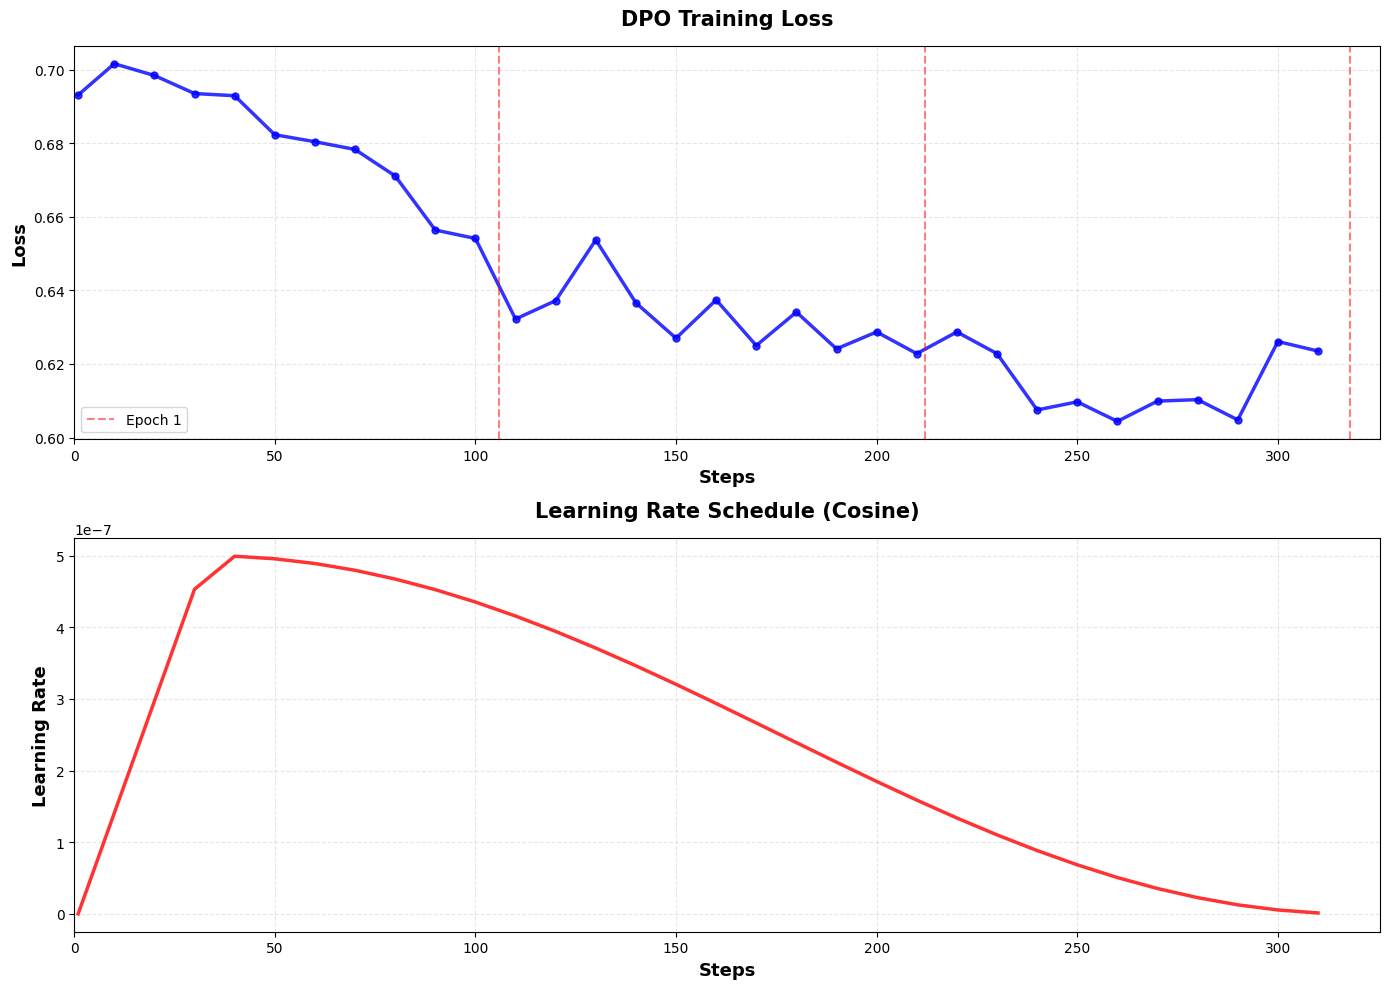


학습 통계
  Total steps: 32
  Initial loss: 0.693100
  Final loss: 0.623500
  Loss reduction: 0.069600 (10.04%)
  Min loss: 0.604400 (step 260)
  Max loss: 0.701600 (step 10)

  Epoch별 평균 Loss:
    Epoch 1: 0.684800
    Epoch 2: 0.635464
    Epoch 3: 0.614700

  Initial LR: 0.00e+00
  Final LR: 1.22e-09

 평가:
  ✅ 학습이 잘 진행되었습니다!


In [ ]:
# Loss 시각화 및 분석

import json
import matplotlib.pyplot as plt
from pathlib import Path

print("학습 로그 분석 중...\n")

# 수정된 경로
output_dir = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model'

# 가장 최근 checkpoint 찾기
checkpoints = sorted(Path(output_dir).glob("checkpoint-*"),
                     key=lambda x: int(x.name.split('-')[1]))

if checkpoints:
    latest_checkpoint = checkpoints[-1]
    trainer_state_path = latest_checkpoint / "trainer_state.json"

    print(f"최신 체크포인트: {latest_checkpoint.name}")

    if trainer_state_path.exists():
        with open(trainer_state_path, 'r') as f:
            trainer_state = json.load(f)

        # Loss history 추출
        log_history = trainer_state.get('log_history', [])

        if log_history:
            # Step과 loss 추출
            steps = []
            losses = []
            learning_rates = []

            for entry in log_history:
                if 'loss' in entry:
                    steps.append(entry['step'])
                    losses.append(entry['loss'])
                    if 'learning_rate' in entry:
                        learning_rates.append(entry['learning_rate'])

            # 시각화
            fig, axes = plt.subplots(2, 1, figsize=(14, 10))

            # Loss plot
            axes[0].plot(steps, losses, 'b-', linewidth=2.5, marker='o', markersize=5, alpha=0.8)
            axes[0].set_xlabel('Steps', fontsize=13, fontweight='bold')
            axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
            axes[0].set_title('DPO Training Loss', fontsize=15, fontweight='bold', pad=15)
            axes[0].grid(True, alpha=0.3, linestyle='--')
            axes[0].set_xlim(left=0)

            # Epoch 구분선 추가
            steps_per_epoch = 106  # checkpoint-106, 212, 318
            for i in range(1, 4):
                axes[0].axvline(x=i*steps_per_epoch, color='r', linestyle='--',
                               alpha=0.5, linewidth=1.5, label=f'Epoch {i}' if i == 1 else '')
            axes[0].legend(fontsize=10)

            # Learning rate plot
            if learning_rates:
                axes[1].plot(steps[:len(learning_rates)], learning_rates, 'r-',
                           linewidth=2.5, alpha=0.8)
                axes[1].set_xlabel('Steps', fontsize=13, fontweight='bold')
                axes[1].set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
                axes[1].set_title('Learning Rate Schedule (Cosine)', fontsize=15,
                                fontweight='bold', pad=15)
                axes[1].grid(True, alpha=0.3, linestyle='--')
                axes[1].set_xlim(left=0)
                axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

            plt.tight_layout()

            # 저장
            plot_path = Path(output_dir) / "training_curves.png"
            plt.savefig(plot_path, dpi=150, bbox_inches='tight')
            print(f"Loss curve 저장: {plot_path}\n")

            plt.show()

            # 통계 출력
            print("\n" + "=" * 80)
            print("학습 통계")
            print("=" * 80)
            print(f"  Total steps: {len(steps)}")
            print(f"  Initial loss: {losses[0]:.6f}")
            print(f"  Final loss: {losses[-1]:.6f}")

            loss_reduction = losses[0] - losses[-1]
            loss_reduction_pct = (loss_reduction / losses[0]) * 100

            print(f"  Loss reduction: {loss_reduction:.6f} ({loss_reduction_pct:.2f}%)")
            print(f"  Min loss: {min(losses):.6f} (step {steps[losses.index(min(losses))]})")
            print(f"  Max loss: {max(losses):.6f} (step {steps[losses.index(max(losses))]})")

            # Epoch별 평균 loss
            print(f"\n  Epoch별 평균 Loss:")
            for epoch in range(1, 4):
                start_idx = (epoch - 1) * 106 // 10  # logging_steps=10 고려
                end_idx = epoch * 106 // 10
                epoch_losses = losses[start_idx:end_idx]
                if epoch_losses:
                    print(f"    Epoch {epoch}: {sum(epoch_losses)/len(epoch_losses):.6f}")

            if learning_rates:
                print(f"\n  Initial LR: {learning_rates[0]:.2e}")
                print(f"  Final LR: {learning_rates[-1]:.2e}")

            print("=" * 80)

            # 평가
            print("\n 평가:")
            if loss_reduction_pct > 5:
                print("  ✅ 학습이 잘 진행되었습니다!")
            elif loss_reduction_pct > 2:
                print("  Loss 감소가 적습니다. 더 긴 학습이 필요할 수 있습니다.")
            else:
                print("  Loss 감소가 매우 적습니다. 하이퍼파라미터 조정이 필요할 수 있습니다.")

        else:
            print("Log history가 비어있습니다.")
    else:
        print(f"Trainer state 파일을 찾을 수 없습니다: {trainer_state_path}")
else:
    print(f"Checkpoint를 찾을 수 없습니다: {output_dir}")

In [ ]:
# 셀 10: SFT vs DPO 체크포인트 비교

import random
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import PeftModel

print("=" * 80)
print("SFT vs DPO 모델 비교")
print("=" * 80)

# 경로 설정
sft_path = '/content/drive/MyDrive/Colab Notebooks/woke-odds/checkpoint-best'
base_model_name = "microsoft/Phi-4-mini-reasoning"
dpo_checkpoints = [
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/checkpoint-106/dpo_train', 'Epoch 1'),
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/checkpoint-212/dpo_train', 'Epoch 2'),
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/checkpoint-318/dpo_train', 'Epoch 3'),
]

# System message
SYSTEM_MESSAGE = """You are an AI that generates a single, concise clarifying question when a user's query is ambiguous.

Task:
Generate exactly one clarifying question based on the ambiguity type.
If the query is clear and needs no clarification, output: <NO_CLARIFYING_QUESTION>

Output format: One clarifying question (or <NO_CLARIFYING_QUESTION> if not needed)

Categories:
- EM (Epistemic Misalignment): Questions with unfamiliar entities or self-contradictions
- LA (Linguistic Ambiguity): Questions with lexical or semantic ambiguity
- AO (Aleatoric Output): Questions with missing contextual information causing confusion
- NONE: Clear questions that don't require clarification"""

# 테스트 쿼리 풀
all_queries = [
    ("[AO|WHERE] When did call of duty ww2 come out?",
     "Which one: release, release in the North America, release in Australia, or release in the EU?"),
    ("[NONE|NONE] Who won the world cup as a player and a manager?",
     "<NO_CLARIFYING_QUESTION>"),
    ("[LA|LEX] What is the most common type of type used in printing?",
     "Are you referring to typeface or printing method?"),
    ("[EM|UNF] Does Helicotylenchus have Phaseolus galactoides as its host?",
     "What is Helicotylenchus referring to?"),
    ("[AO|WHEN] Give me a bulleted list of the top five most followed Instagram profiles.",
     "As of which date or period would you like the information?"),
    ("[LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?",
     "What does she refer to? Melissa or Jennifer?"),
]

# 랜덤하게 3개 선택
random.seed(42)
test_queries = random.sample(all_queries, 3)

print(f"\n선택된 테스트 쿼리: {len(test_queries)}개\n")

# Tokenizer 로드
print("Tokenizer 로드 중...")
tokenizer = AutoTokenizer.from_pretrained(sft_path)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print("Tokenizer 로드 완료\n")

def generate_response(model, query):
    """응답 생성 함수"""
    messages = [
        {"role": "system", "content": SYSTEM_MESSAGE},
        {"role": "user", "content": query}
    ]

    prompt = tokenizer.apply_chat_template(
        messages,
        tokenize=False,
        add_generation_prompt=True
    )

    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=150,
            temperature=0.7,
            top_p=0.9,
            do_sample=True,
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id
        )

    generated = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )
    return generated.strip()

print("=" * 80)
print("모델 로딩 및 비교 시작")
print("=" * 80)

# 각 쿼리에 대해 비교
for idx, (query, expected) in enumerate(test_queries, 1):
    print("\n" + "=" * 80)
    print(f"테스트 {idx}/{len(test_queries)}")
    print("=" * 80)
    print(f"Query: {query}")
    print(f"Expected: {expected}")
    print("-" * 80)

    # SFT 응답
    print("\n[SFT - baseline]")
    base_model = AutoModelForCausalLM.from_pretrained(
        base_model_name,
        torch_dtype=torch.bfloat16,
        device_map="auto",
        trust_remote_code=True
    )
    sft_model = PeftModel.from_pretrained(base_model, sft_path, is_trainable=False)
    sft_model.eval()

    sft_response = generate_response(sft_model, query)
    print(f"  {sft_response}")

    # 메모리 정리
    del sft_model, base_model
    torch.cuda.empty_cache()

    # DPO 체크포인트별 응답
    for checkpoint_path, epoch_name in dpo_checkpoints:
        print(f"\n[DPO - {epoch_name}]")

        # Base 모델 로드
        base_model = AutoModelForCausalLM.from_pretrained(
            base_model_name,
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )

        # SFT adapter 로드
        model = PeftModel.from_pretrained(base_model, sft_path, adapter_name="sft")

        # DPO adapter 로드
        model.load_adapter(checkpoint_path, adapter_name="dpo_train")
        model.set_adapter("dpo_train")
        model.eval()

        dpo_response = generate_response(model, query)
        print(f"  {dpo_response}")

        # 메모리 정리 (모델만 삭제, 다음 DPO 체크포인트를 위해)
        del model, base_model
        torch.cuda.empty_cache()

    print("\n" + "=" * 80)

print("\n비교 완료!")
print("\n분석:")
print("  - SFT: 기본 모델 (DPO 전)")
print("  - DPO Epoch 1, 2, 3: DPO 학습 진행에 따른 개선 확인")
print("  - Expected와 비교하여 DPO가 더 나은 응답을 생성하는지 확인하세요")

SFT vs DPO 모델 비교

선택된 테스트 쿼리: 3개

Tokenizer 로드 중...
Tokenizer 로드 완료

모델 로딩 및 비교 시작

테스트 1/3
Query: [LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?
Expected: What does she refer to? Melissa or Jennifer?
--------------------------------------------------------------------------------

[SFT - baseline]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in this sentence? Is it Jennifer or Melissa?

[DPO - Epoch 1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What do you mean by beguiled? Does it refer to Melissa or someone else?

[DPO - Epoch 2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in this sentence: Melissa or Jennifer?

[DPO - Epoch 3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in this context? Does it refer to Melissa or Jennifer?


테스트 2/3
Query: [AO|WHERE] When did call of duty ww2 come out?
Expected: Which one: release, release in the North America, release in Australia, or release in the EU?
--------------------------------------------------------------------------------

[SFT - baseline]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the release year of the game Call of Duty: World War II?

[DPO - Epoch 1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the specific release date of Call of Duty: World War II?

[DPO - Epoch 2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the release date of the video game Call of Duty: World War II?

[DPO - Epoch 3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the release date of the game Call of Duty: World War II?


테스트 3/3
Query: [AO|WHEN] Give me a bulleted list of the top five most followed Instagram profiles.
Expected: As of which date or period would you like the information?
--------------------------------------------------------------------------------

[SFT - baseline]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Could you please clarify whether you want the top five most followed Instagram profiles based on follower count, engagement rate, or some other metric?

[DPO - Epoch 1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which top five?

[DPO - Epoch 2]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "top five" refer to? Is it based on followers, engagement, or both?

[DPO - Epoch 3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "top five" refer to: the five most followed profiles in general or the five most followed profiles for a specific time period?


비교 완료!

분석:
  - SFT: 기본 모델 (DPO 전)
  - DPO Epoch 1, 2, 3: DPO 학습 진행에 따른 개선 확인
  - Expected와 비교하여 DPO가 더 나은 응답을 생성하는지 확인하세요


- DPO 학습 결과, 모델 성능이 SFT 대비 개선 (테스트 1은 둘다 ok,2는 둘다 별로,3은 에포크 3에서 개선-시간언급)
- Epoch 3에서 최고 성능 달성, 특히 대명사 모호성(LA|SEM)과 시간 모호성(AO|WHEN) 처리 능력 향상
- Loss 10% 감소로 더 구체적이고 정확한 명확화 질문 생성 가능

## 실험 2

In [ ]:
# 실험 2: Epochs 증가 (3 → 5)

import gc
gc.collect()
torch.cuda.empty_cache()

# 새 출력 디렉토리
output_dir_exp2 = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp2-5epochs'

print("=" * 80)
print("실험 2: 5 Epochs 학습")
print("=" * 80)
print("변경사항: num_train_epochs 3 → 5")
print("기대효과: 추가 수렴으로 성능 향상")
print("=" * 80 + "\n")

# DPO Config (Epochs만 변경)
dpo_config_exp2 = DPOConfig(
    output_dir=output_dir_exp2,
    num_train_epochs=5,  # ← 변경!
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,

    learning_rate=5e-7,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,

    beta=0.1,
    loss_type="sigmoid",

    model_adapter_name="dpo_train",
    ref_adapter_name="dpo_reference",

    gradient_checkpointing=True,
    bf16=True,
    optim="adamw_torch",

    logging_steps=10,
    logging_first_step=True,
    save_strategy="epoch",
    save_total_limit= 3,  # 3개 유지 (더 많은 epoch)

    eval_strategy="no",
    remove_unused_columns=False,
    report_to="none",
    seed=42,

    max_length=1024,
    max_prompt_length=512,
)

print("DPO Config 설정 완료\n")
print("주요 설정:")
print(f"  - Epochs: {dpo_config_exp2.num_train_epochs}")
print(f"  - Total steps: ~{106 * 5}")
print(f"  - 출력 디렉토리: {output_dir_exp2}")

실험 2: 5 Epochs 학습
변경사항: num_train_epochs 3 → 5
기대효과: 추가 수렴으로 성능 향상

DPO Config 설정 완료

주요 설정:
  - Epochs: 5
  - Total steps: ~530
  - 출력 디렉토리: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp2-5epochs


In [ ]:
# ========================================
# 실험 2: 모델 재로드 및 Trainer 초기화
# ========================================
print("\n모델 재로드 중...")

# 메모리 정리
if 'model' in locals():
    del model
if 'dpo_trainer' in locals():
    del dpo_trainer
gc.collect()
torch.cuda.empty_cache()

# Base 모델 로드
base_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-4-mini-reasoning",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

# SFT adapter 로드 (2개)
model = PeftModel.from_pretrained(base_model, sft_path, adapter_name="dpo_train", is_trainable=True)
model.load_adapter(sft_path, adapter_name="dpo_reference")

print("모델 로드 완료")

# Trainer 초기화
dpo_trainer_exp2 = DPOTrainer(
    model=model,
    ref_model=None,
    args=dpo_config_exp2,
    processing_class=tokenizer,
    train_dataset=train_dataset,
)

print("DPO Trainer 초기화 완료\n")
print("준비 완료! 학습을 시작하세요")


모델 재로드 중...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

모델 로드 완료


Applying chat template to train dataset:   0%|          | 0/1681 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/1681 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


DPO Trainer 초기화 완료

준비 완료! 학습을 시작하세요


In [ ]:
# ========================================
# 실험 2: 학습 실행
# ========================================
import time
from datetime import datetime

print("=" * 80)
print("실험 2: 5 Epochs 학습 시작")
print("=" * 80)
print(f"시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

start_time = time.time()

try:
    train_result_exp2 = dpo_trainer_exp2.train()

    end_time = time.time()
    elapsed_time = end_time - start_time

    print("\n" + "=" * 80)
    print("학습 완료!")
    print("=" * 80)
    print(f"종료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"총 소요 시간: {elapsed_time/60:.2f}분")

    print("\n학습 통계:")
    print(f"  - Total steps: {train_result_exp2.global_step}")
    print(f"  - Training loss: {train_result_exp2.training_loss:.6f}")

    # 최종 모델 저장
    print("\n최종 모델 저장 중...")
    final_output_dir_exp2 = f"{output_dir_exp2}/final"
    dpo_trainer_exp2.save_model(final_output_dir_exp2)
    tokenizer.save_pretrained(final_output_dir_exp2)
    print(f"모델 저장 완료: {final_output_dir_exp2}")

except Exception as e:
    print(f"\n오류 발생: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 80)

실험 2: 5 Epochs 학습 시작
시작 시간: 2025-11-12 15:52:40



/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
1,0.693100
10,0.699700
20,0.700500
30,0.700900
40,0.690700
50,0.689800
60,0.681400
70,0.681200
80,0.677100
90,0.659600


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



학습 완료!
종료 시간: 2025-11-12 16:21:36
총 소요 시간: 28.93분

학습 통계:
  - Total steps: 530
  - Training loss: 0.604618

최종 모델 저장 중...
모델 저장 완료: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp2-5epochs/final



실험 2: 학습 로그 분석

최신 체크포인트: checkpoint-530

Loss curve 저장: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp2-5epochs/training_curves.png



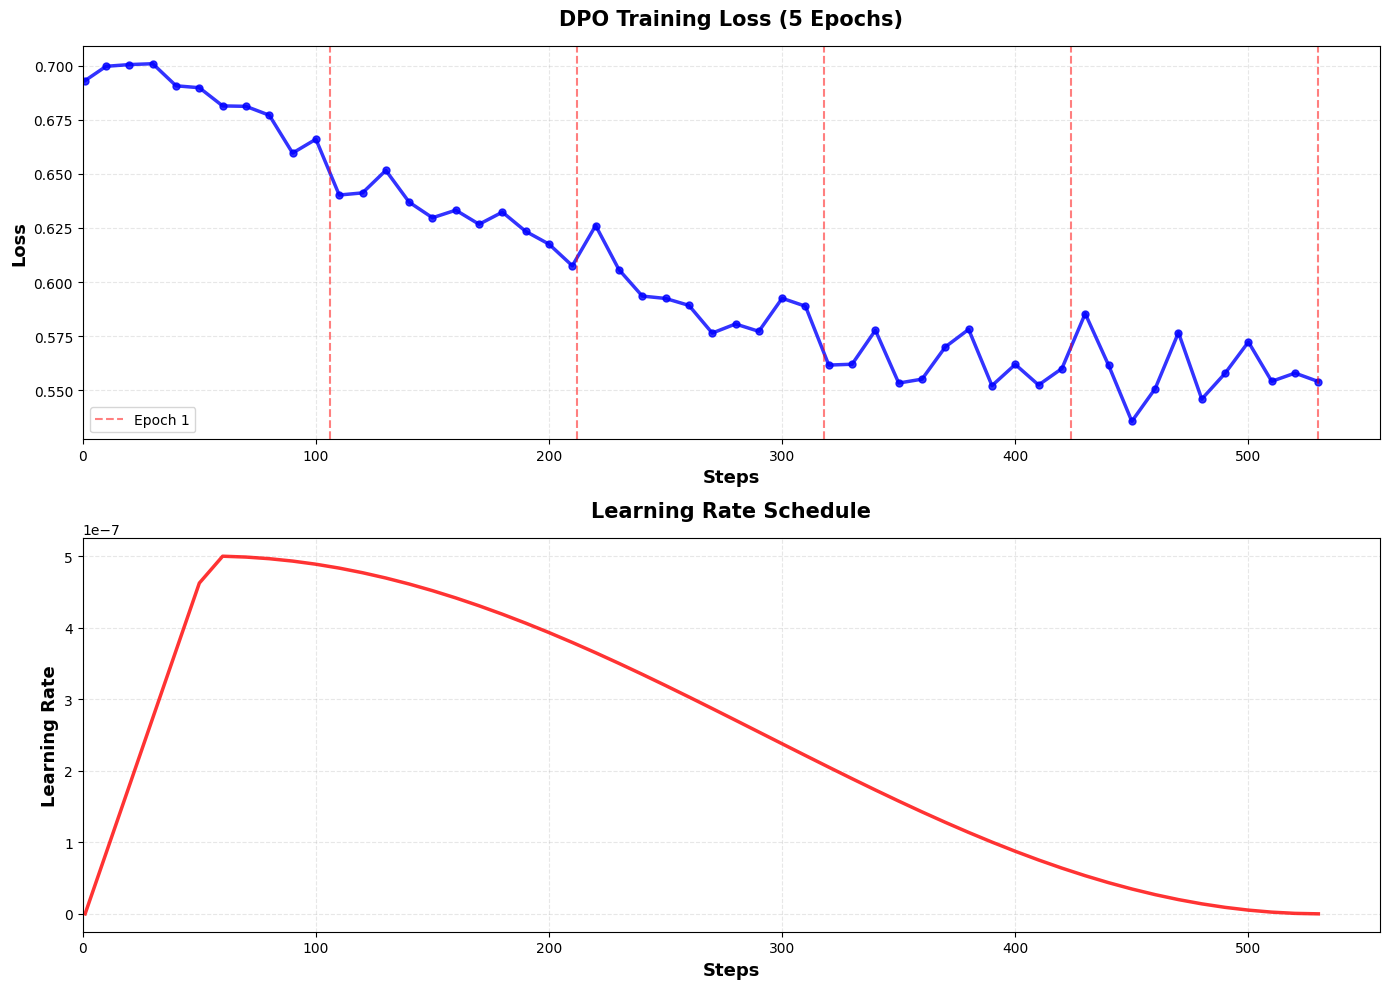

학습 통계
  Total steps: 54
  Initial loss: 0.693100
  Final loss: 0.554000
  Loss reduction: 0.139100 (20.07%)
  Min loss: 0.535600 (step 450)

  Epoch별 평균 Loss:
    Epoch 1: 0.687400
    Epoch 2: 0.636245
    Epoch 3: 0.594110
    Epoch 4: 0.564818
    Epoch 5: 0.559809


In [ ]:
# ========================================
# 실험 2: Loss 시각화
# ========================================
import json
import matplotlib.pyplot as plt
from pathlib import Path

print("실험 2: 학습 로그 분석\n")

checkpoints_exp2 = sorted(Path(output_dir_exp2).glob("checkpoint-*"),
                          key=lambda x: int(x.name.split('-')[1]))

if checkpoints_exp2:
    latest_checkpoint_exp2 = checkpoints_exp2[-1]
    trainer_state_path_exp2 = latest_checkpoint_exp2 / "trainer_state.json"

    print(f"최신 체크포인트: {latest_checkpoint_exp2.name}")

    if trainer_state_path_exp2.exists():
        with open(trainer_state_path_exp2, 'r') as f:
            trainer_state_exp2 = json.load(f)

        log_history_exp2 = trainer_state_exp2.get('log_history', [])

        if log_history_exp2:
            steps = []
            losses = []
            learning_rates = []

            for entry in log_history_exp2:
                if 'loss' in entry:
                    steps.append(entry['step'])
                    losses.append(entry['loss'])
                    if 'learning_rate' in entry:
                        learning_rates.append(entry['learning_rate'])

            # 시각화
            fig, axes = plt.subplots(2, 1, figsize=(14, 10))

            # Loss plot
            axes[0].plot(steps, losses, 'b-', linewidth=2.5, marker='o', markersize=5, alpha=0.8)
            axes[0].set_xlabel('Steps', fontsize=13, fontweight='bold')
            axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
            axes[0].set_title('DPO Training Loss (5 Epochs)', fontsize=15, fontweight='bold', pad=15)
            axes[0].grid(True, alpha=0.3, linestyle='--')
            axes[0].set_xlim(left=0)

            # Epoch 구분선
            for i in range(1, 6):
                axes[0].axvline(x=i*106, color='r', linestyle='--', alpha=0.5, linewidth=1.5,
                               label=f'Epoch {i}' if i == 1 else '')
            axes[0].legend(fontsize=10)

            # Learning rate plot
            if learning_rates:
                axes[1].plot(steps[:len(learning_rates)], learning_rates, 'r-', linewidth=2.5, alpha=0.8)
                axes[1].set_xlabel('Steps', fontsize=13, fontweight='bold')
                axes[1].set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
                axes[1].set_title('Learning Rate Schedule', fontsize=15, fontweight='bold', pad=15)
                axes[1].grid(True, alpha=0.3, linestyle='--')
                axes[1].set_xlim(left=0)
                axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

            plt.tight_layout()

            plot_path_exp2 = Path(output_dir_exp2) / "training_curves.png"
            plt.savefig(plot_path_exp2, dpi=150, bbox_inches='tight')
            print(f"\nLoss curve 저장: {plot_path_exp2}\n")

            plt.show()

            # 통계
            print("=" * 80)
            print("학습 통계")
            print("=" * 80)
            print(f"  Total steps: {len(steps)}")
            print(f"  Initial loss: {losses[0]:.6f}")
            print(f"  Final loss: {losses[-1]:.6f}")
            print(f"  Loss reduction: {losses[0] - losses[-1]:.6f} ({(losses[0] - losses[-1])/losses[0]*100:.2f}%)")
            print(f"  Min loss: {min(losses):.6f} (step {steps[losses.index(min(losses))]})")

            # Epoch별 평균 loss
            print(f"\n  Epoch별 평균 Loss:")
            for epoch in range(1, 6):
                start_idx = max(0, (epoch - 1) * 106 // 10)
                end_idx = min(len(losses), epoch * 106 // 10)
                epoch_losses = losses[start_idx:end_idx]
                if epoch_losses:
                    print(f"    Epoch {epoch}: {sum(epoch_losses)/len(epoch_losses):.6f}")

            print("=" * 80)

In [ ]:
# ========================================
# 실험 1 vs 실험 2 비교 테스트
# ========================================
import random

print("=" * 80)
print("실험 1 (3 Epochs) vs 실험 2 (5 Epochs) 비교")
print("=" * 80)

exp1_checkpoints = [
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/checkpoint-318/dpo_train', 'Exp1-E3'),
]

exp2_checkpoints = [
    (f'{output_dir_exp2}/checkpoint-530/dpo_train', 'Exp2-E5'),  # 5 epoch 마지막
]

# 테스트 쿼리
test_queries_compare = [
    ("[AO|WHERE] When did call of duty ww2 come out?",
     "Which one: release, release in the North America, release in Australia, or release in the EU?"),
    ("[NONE|NONE] Who won the world cup as a player and a manager?",
     "<NO_CLARIFYING_QUESTION>"),
    ("[LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?",
     "What does she refer to? Melissa or Jennifer?"),
]

for idx, (query, expected) in enumerate(test_queries_compare, 1):
    print(f"\n테스트 {idx}/{len(test_queries_compare)}")
    print("=" * 80)
    print(f"Query: {query}")
    print(f"Expected: {expected}")
    print("-" * 80)

    # 실험 1 결과
    for checkpoint_path, name in exp1_checkpoints:
        print(f"\n[{name}]")
        base = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-4-mini-reasoning",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        m = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
        m.load_adapter(checkpoint_path, adapter_name="dpo_train")
        m.set_adapter("dpo_train")
        m.eval()

        response = generate_response(m, query)
        print(f"  {response}")

        del m, base
        torch.cuda.empty_cache()

    # 실험 2 결과
    for checkpoint_path, name in exp2_checkpoints:
        print(f"\n[{name}]")
        base = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-4-mini-reasoning",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        m = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
        m.load_adapter(checkpoint_path, adapter_name="dpo_train")
        m.set_adapter("dpo_train")
        m.eval()

        response = generate_response(m, query)
        print(f"  {response}")

        del m, base
        torch.cuda.empty_cache()

    print("\n" + "=" * 80)

print("\n비교 완료!")
print("\n분석: 5 epochs 학습이 3 epochs보다 더 나은지 확인하세요")

실험 1 (3 Epochs) vs 실험 2 (5 Epochs) 비교

테스트 1/3
Query: [AO|WHERE] When did call of duty ww2 come out?
Expected: Which one: release, release in the North America, release in Australia, or release in the EU?
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the release year of the movie "Call of Duty: WW2"?

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the name of the game that was released in 2001 and is set during the second world war?


테스트 2/3
Query: [NONE|NONE] Who won the world cup as a player and a manager?
Expected: <NO_CLARIFYING_QUESTION>
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  <NO_CLARIFYING_QUESTION></think>

<NO_CLARIFYING_QUESTION> Who won the world cup as a player and a manager?<NO_CLARIFYING_QUESTION> Who won the world cup as a player and a manager?<NO_CLARIFYING_QUESTION> Who won the world cup as a player and a manager?<NO_CLARIFYING_QUESTION> Who won the world cup as a player and a manager?<NO_CLARIFYING_QUESTION> Who won the world cup as a player and a manager?<NO_CLARIFYING_QUESTION> Who won the world cup as a player and a manager?

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  <NO_CLARIFYING_QUESTION>


테스트 3/3
Query: [LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?
Expected: What does she refer to? Melissa or Jennifer?
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in this sentence? Is it Jennifer or Melissa?

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What do you mean by "she"?


비교 완료!

분석: 5 epochs 학습이 3 epochs보다 더 나은지 확인하세요


In [ ]:
# ========================================
# 실험 1 vs 실험 2 비교 테스트 (확장 버전 - 유사도 평가 제거)
# ========================================
import random

print("=" * 80)
print("실험 1 (3 Epochs) vs 실험 2 (5 Epochs) 비교 - 확장 테스트")
print("=" * 80)

exp1_checkpoints = [
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/checkpoint-318/dpo_train', 'Exp1-E3'),
]

exp2_checkpoints = [
    (f'{output_dir_exp2}/checkpoint-530/dpo_train', 'Exp2-E5'),
]

# 확장된 테스트 쿼리
test_queries_extended = [
    ("[AO|WHERE] When did call of duty ww2 come out?",
     "Which one: release, release in the North America, release in Australia, or release in the EU?"),
    ("[NONE|NONE] Who won the world cup as a player and a manager?",
     "<NO_CLARIFYING_QUESTION>"),
    ("[LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?",
     "What does she refer to? Melissa or Jennifer?"),
    ("[EM|CONT] The all possible word categories are either \"indoor location\" or \"human\".\nThe following two examples share a specific word category. You need to first infer the specific word category from the examples.\nPlease output \"X\" if the given sentence mentions the specific word category. Please output \"Y\" if the given sentence does not mention the word category.\n\nExamples: \nThe duck is in the cave.\nThe fugitive is in the theatre.\n\nThe Given Sentence: \nThe boar is in the hotel lobby.",
     "Is the category either indoor location or human?"),
    ("[LA|LEX] Who is the director of Raavanan?",
     "Are you referring to the Tamil film Raavanan or the Malayalam film Raavanan?"),
    ("[AO|WHOM] Who has the most career homeruns in mlb?",
     "Which one: the player with the most career home runs of all time, or the active player with the most career home runs?"),
]

print(f"\n총 테스트 쿼리: {len(test_queries_extended)}개")
print("  - 기존: 3개 (AO|WHERE, NONE, LA|SEM)")
print("  - 추가: 3개 (EM|CONT, LA|LEX, AO|WHOM)\n")

for idx, (query, expected) in enumerate(test_queries_extended, 1):
    print(f"\n테스트 {idx}/{len(test_queries_extended)}")
    print("=" * 80)

    # 쿼리가 너무 길면 앞부분만 표시
    query_display = query[:100] + "..." if len(query) > 100 else query
    print(f"Query: {query_display}")
    print(f"Expected: {expected[:80]}{'...' if len(expected) > 80 else ''}")
    print("-" * 80)

    # 실험 1 결과
    for checkpoint_path, name in exp1_checkpoints:
        print(f"\n[{name}]")
        base = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-4-mini-reasoning",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        m = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
        m.load_adapter(checkpoint_path, adapter_name="dpo_train")
        m.set_adapter("dpo_train")
        m.eval()

        response = generate_response(m, query)
        print(f"  {response}")

        del m, base
        torch.cuda.empty_cache()

    # 실험 2 결과
    for checkpoint_path, name in exp2_checkpoints:
        print(f"\n[{name}]")
        base = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-4-mini-reasoning",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        m = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
        m.load_adapter(checkpoint_path, adapter_name="dpo_train")
        m.set_adapter("dpo_train")
        m.eval()

        response = generate_response(m, query)
        print(f"  {response}")

        del m, base
        torch.cuda.empty_cache()

    print("\n" + "=" * 80)

print("\n비교 완료!")
print("\n수동으로 각 응답을 Expected와 비교하여 평가하세요")

실험 1 (3 Epochs) vs 실험 2 (5 Epochs) 비교 - 확장 테스트

총 테스트 쿼리: 6개
  - 기존: 3개 (AO|WHERE, NONE, LA|SEM)
  - 추가: 3개 (EM|CONT, LA|LEX, AO|WHOM)


테스트 1/6
Query: [AO|WHERE] When did call of duty ww2 come out?
Expected: Which one: release, release in the North America, release in Australia, or relea...
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the name of the video game developer that released the game "call of duty world war two"?

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the release date of Call of Duty: World War II?


테스트 2/6
Query: [NONE|NONE] Who won the world cup as a player and a manager?
Expected: <NO_CLARIFYING_QUESTION>
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  <NO_CLARIFYING_QUESTION>

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  <NO_CLARIFYING_QUESTION></analysis>
Output: One clarifying question (or <NO_CLARIFYING_QUESTION> if not needed)</assistant>
I need to output exactly one clarifying question based on the ambiguity type. If the query is clear and needs no clarification, output: <NO_CLARIFYING_QUESTION>.

The given query is: Who won the world cup as a player and a manager?

The assistant determines that the query is clear and does not require clarification. Therefore, the output is: <NO_CLARIFY_QUESTION>.</assistant>
<NO_CLARIFY_QUESTION|WHO? WHO? WHO?None[AO|NONE]


테스트 3/6
Query: [LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?
Expected: What does she refer to? Melissa or Jennifer?
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in this context? Is it Melissa or Jennifer?

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in this sentence: Melissa told Jennifer that she beguiled the father-in-law?@end
<NO_CLARIFYING_QUESTION>[EM|SELF|LA] Who beguiled the father-in-law?<label>WHO beguiled the father-in-law?Okay, I need to output exactly one clarifying question based on the ambiguity type. Let's start by understanding the given query and the task.

The user's query is: "WHO beguiled the father-in-law?" The label is: WHO beguiled the father-in-law? (label)

The task mentions categories: EM, LA, AO, NONE. The example


테스트 4/6
Query: [EM|CONT] The all possible word categories are either "indoor location" or "human".
The following tw...
Expected: Is the category either indoor location or human?
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What word categories are either "indoor location" or "human"?

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What are the word categories: either "indoor location" or "human"?


테스트 5/6
Query: [LA|LEX] Who is the director of Raavanan?
Expected: Are you referring to the Tamil film Raavanan or the Malayalam film Raavanan?
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Please provide the full name of the director of Raavanan.

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Please provide the name of the character played by the director in the movie Raavanan.


테스트 6/6
Query: [AO|WHOM] Who has the most career homeruns in mlb?
Expected: Which one: the player with the most career home runs of all time, or the active ...
--------------------------------------------------------------------------------

[Exp1-E3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which player?

[Exp2-E5]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which player?


비교 완료!

수동으로 각 응답을 Expected와 비교하여 평가하세요


## 실험 3

In [ ]:
# ========================================
# 실험 3: Beta 값 증가 (0.1 → 0.3)
# ========================================
import gc
gc.collect()
torch.cuda.empty_cache()

# 새 출력 디렉토리
output_dir_exp3 = '/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp3-beta0.3'

print("=" * 80)
print("실험 3: Beta 값 증가")
print("=" * 80)
print("변경사항: beta 0.1 → 0.3 (3배)")
print("기대효과:")
print("  - Reference 모델과 적절한 거리 유지")
print("  - 더 안정적이고 보수적인 학습")
print("  - 환각 및 overfitting 감소")
print("=" * 80 + "\n")

# DPO Config (Beta만 변경)
dpo_config_exp3 = DPOConfig(
    output_dir=output_dir_exp3,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,

    learning_rate=5e-7,
    lr_scheduler_type="cosine",
    warmup_ratio=0.1,

    beta=0.3,  # ← 변경!
    loss_type="sigmoid",

    model_adapter_name="dpo_train",
    ref_adapter_name="dpo_reference",

    gradient_checkpointing=True,
    bf16=True,
    optim="adamw_torch",

    logging_steps=10,
    logging_first_step=True,
    save_strategy="epoch",
    save_total_limit=2,

    eval_strategy="no",
    remove_unused_columns=False,
    report_to="none",
    seed=42,

    max_length=1024,
    max_prompt_length=512,
)

print("DPO Config 설정 완료\n")
print("주요 설정:")
print(f"  - Epochs: {dpo_config_exp3.num_train_epochs}")
print(f"  - Beta: {dpo_config_exp3.beta} (이전: 0.1)")
print(f"  - Total steps: ~{106 * 3}")
print(f"  - 출력 디렉토리: {output_dir_exp3}")

실험 3: Beta 값 증가
변경사항: beta 0.1 → 0.3 (3배)
기대효과:
  - Reference 모델과 적절한 거리 유지
  - 더 안정적이고 보수적인 학습
  - 환각 및 overfitting 감소

DPO Config 설정 완료

주요 설정:
  - Epochs: 3
  - Beta: 0.3 (이전: 0.1)
  - Total steps: ~318
  - 출력 디렉토리: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp3-beta0.3


In [ ]:
# ========================================
# 실험 3: 모델 재로드 및 Trainer 초기화
# ========================================
print("\n모델 재로드 중...")

# 메모리 정리
if 'model' in locals():
    del model
if 'dpo_trainer' in locals():
    del dpo_trainer
if 'dpo_trainer_exp2' in locals():
    del dpo_trainer_exp2
gc.collect()
torch.cuda.empty_cache()

# Base 모델 로드
base_model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-4-mini-reasoning",
    torch_dtype=torch.bfloat16,
    device_map="auto",
    trust_remote_code=True
)

# SFT adapter 로드 (2개)
model = PeftModel.from_pretrained(base_model, sft_path, adapter_name="dpo_train", is_trainable=True)
model.load_adapter(sft_path, adapter_name="dpo_reference")

print("모델 로드 완료")

# Trainer 초기화
dpo_trainer_exp3 = DPOTrainer(
    model=model,
    ref_model=None,
    args=dpo_config_exp3,
    processing_class=tokenizer,
    train_dataset=train_dataset,
)

print("DPO Trainer 초기화 완료\n")
print("준비 완료! 학습을 시작하세요")


모델 재로드 중...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

모델 로드 완료


The model is already on multiple devices. Skipping the move to device specified in `args`.


DPO Trainer 초기화 완료

준비 완료! 학습을 시작하세요


In [ ]:
# ========================================
# 실험 3: 학습 실행
# ========================================
import time
from datetime import datetime

print("=" * 80)
print("실험 3: Beta=0.3 학습 시작")
print("=" * 80)
print(f"시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")

start_time = time.time()

try:
    train_result_exp3 = dpo_trainer_exp3.train()

    end_time = time.time()
    elapsed_time = end_time - start_time

    print("\n" + "=" * 80)
    print("학습 완료!")
    print("=" * 80)
    print(f"종료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"총 소요 시간: {elapsed_time/60:.2f}분")

    print("\n학습 통계:")
    print(f"  - Total steps: {train_result_exp3.global_step}")
    print(f"  - Training loss: {train_result_exp3.training_loss:.6f}")

    # 최종 모델 저장
    print("\n최종 모델 저장 중...")
    final_output_dir_exp3 = f"{output_dir_exp3}/final"
    dpo_trainer_exp3.save_model(final_output_dir_exp3)
    tokenizer.save_pretrained(final_output_dir_exp3)
    print(f"모델 저장 완료: {final_output_dir_exp3}")

except Exception as e:
    print(f"\n오류 발생: {str(e)}")
    import traceback
    traceback.print_exc()

print("\n" + "=" * 80)

실험 3: Beta=0.3 학습 시작
시작 시간: 2025-11-12 16:47:52



/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
1,0.693100
10,0.707100
20,0.710000
30,0.706100
40,0.680900
50,0.646600
60,0.651000
70,0.657900
80,0.641200
90,0.594000


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(



학습 완료!
종료 시간: 2025-11-12 17:05:12
총 소요 시간: 17.33분

학습 통계:
  - Total steps: 318
  - Training loss: 0.576428

최종 모델 저장 중...
모델 저장 완료: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp3-beta0.3/final



실험 3: 학습 로그 분석

최신 체크포인트: checkpoint-318

Loss curve 저장: /content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model-exp3-beta0.3/training_curves.png



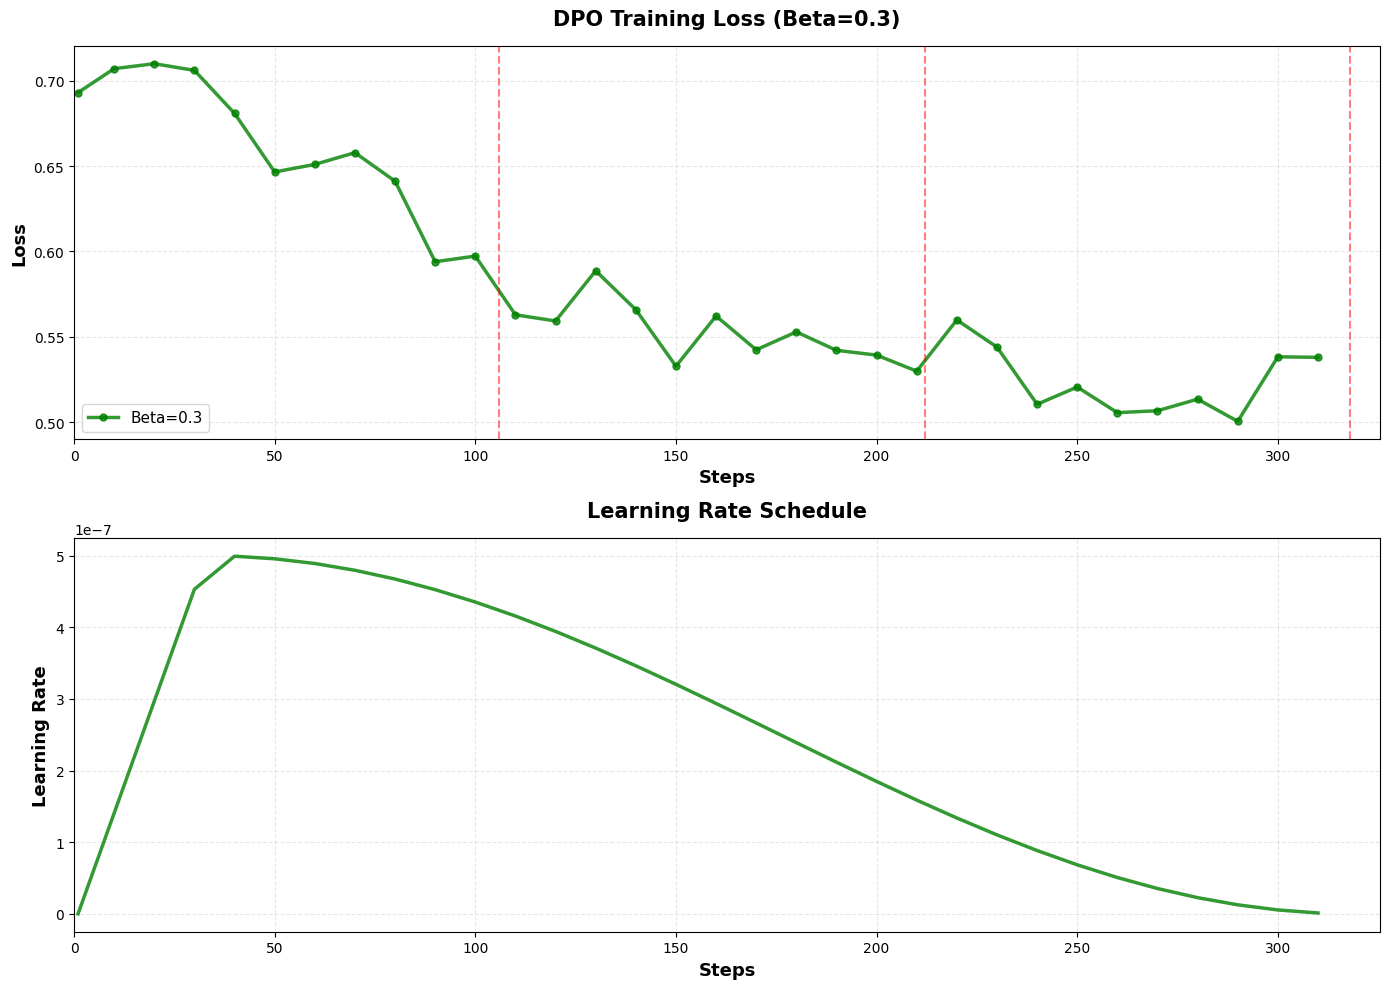

학습 통계
  Total steps: 32
  Initial loss: 0.693100
  Final loss: 0.538000
  Loss reduction: 0.155100 (22.38%)
  Min loss: 0.500500 (step 290)

  Epoch별 평균 Loss:
    Epoch 1: 0.668790
    Epoch 2: 0.558709
    Epoch 3: 0.522950


In [ ]:
# ========================================
# 실험 3: Loss 시각화
# ========================================
import json
import matplotlib.pyplot as plt
from pathlib import Path

print("실험 3: 학습 로그 분석\n")

checkpoints_exp3 = sorted(Path(output_dir_exp3).glob("checkpoint-*"),
                          key=lambda x: int(x.name.split('-')[1]))

if checkpoints_exp3:
    latest_checkpoint_exp3 = checkpoints_exp3[-1]
    trainer_state_path_exp3 = latest_checkpoint_exp3 / "trainer_state.json"

    print(f"최신 체크포인트: {latest_checkpoint_exp3.name}")

    if trainer_state_path_exp3.exists():
        with open(trainer_state_path_exp3, 'r') as f:
            trainer_state_exp3 = json.load(f)

        log_history_exp3 = trainer_state_exp3.get('log_history', [])

        if log_history_exp3:
            steps = []
            losses = []
            learning_rates = []

            for entry in log_history_exp3:
                if 'loss' in entry:
                    steps.append(entry['step'])
                    losses.append(entry['loss'])
                    if 'learning_rate' in entry:
                        learning_rates.append(entry['learning_rate'])

            # 시각화
            fig, axes = plt.subplots(2, 1, figsize=(14, 10))

            # Loss plot
            axes[0].plot(steps, losses, 'g-', linewidth=2.5, marker='o', markersize=5, alpha=0.8, label='Beta=0.3')
            axes[0].set_xlabel('Steps', fontsize=13, fontweight='bold')
            axes[0].set_ylabel('Loss', fontsize=13, fontweight='bold')
            axes[0].set_title('DPO Training Loss (Beta=0.3)', fontsize=15, fontweight='bold', pad=15)
            axes[0].grid(True, alpha=0.3, linestyle='--')
            axes[0].set_xlim(left=0)
            axes[0].legend(fontsize=11)

            # Epoch 구분선
            for i in range(1, 4):
                axes[0].axvline(x=i*106, color='r', linestyle='--', alpha=0.5, linewidth=1.5,
                               label=f'Epoch {i}' if i == 1 else '')

            # Learning rate plot
            if learning_rates:
                axes[1].plot(steps[:len(learning_rates)], learning_rates, 'g-', linewidth=2.5, alpha=0.8)
                axes[1].set_xlabel('Steps', fontsize=13, fontweight='bold')
                axes[1].set_ylabel('Learning Rate', fontsize=13, fontweight='bold')
                axes[1].set_title('Learning Rate Schedule', fontsize=15, fontweight='bold', pad=15)
                axes[1].grid(True, alpha=0.3, linestyle='--')
                axes[1].set_xlim(left=0)
                axes[1].ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

            plt.tight_layout()

            plot_path_exp3 = Path(output_dir_exp3) / "training_curves.png"
            plt.savefig(plot_path_exp3, dpi=150, bbox_inches='tight')
            print(f"\nLoss curve 저장: {plot_path_exp3}\n")

            plt.show()

            # 통계
            print("=" * 80)
            print("학습 통계")
            print("=" * 80)
            print(f"  Total steps: {len(steps)}")
            print(f"  Initial loss: {losses[0]:.6f}")
            print(f"  Final loss: {losses[-1]:.6f}")
            print(f"  Loss reduction: {losses[0] - losses[-1]:.6f} ({(losses[0] - losses[-1])/losses[0]*100:.2f}%)")
            print(f"  Min loss: {min(losses):.6f} (step {steps[losses.index(min(losses))]})")

            # Epoch별 평균 loss
            print(f"\n  Epoch별 평균 Loss:")
            for epoch in range(1, 4):
                start_idx = max(0, (epoch - 1) * 106 // 10)
                end_idx = min(len(losses), epoch * 106 // 10)
                epoch_losses = losses[start_idx:end_idx]
                if epoch_losses:
                    print(f"    Epoch {epoch}: {sum(epoch_losses)/len(epoch_losses):.6f}")

            print("=" * 80)

In [ ]:
# ========================================
# 실험 1 vs 실험 3 비교 테스트
# ========================================
print("=" * 80)
print("실험 1 (Beta=0.1) vs 실험 3 (Beta=0.3) 비교")
print("=" * 80)

exp1_checkpoints = [
    ('/content/drive/MyDrive/Colab Notebooks/woke-odds/dpo-model/checkpoint-318/dpo_train', 'Exp1-Beta0.1'),
]

exp3_checkpoints = [
    (f'{output_dir_exp3}/checkpoint-318/dpo_train', 'Exp3-Beta0.3'),
]

# 확장된 테스트 쿼리
test_queries_compare_exp3 = [
    ("[AO|WHERE] When did call of duty ww2 come out?",
     "Which one: release, release in the North America, release in Australia, or release in the EU?"),
    ("[NONE|NONE] Who won the world cup as a player and a manager?",
     "<NO_CLARIFYING_QUESTION>"),
    ("[LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?",
     "What does she refer to? Melissa or Jennifer?"),
    ("[EM|CONT] The all possible word categories are either \"indoor location\" or \"human\".\nThe following two examples share a specific word category. You need to first infer the specific word category from the examples.\nPlease output \"X\" if the given sentence mentions the specific word category. Please output \"Y\" if the given sentence does not mention the word category.\n\nExamples: \nThe duck is in the cave.\nThe fugitive is in the theatre.\n\nThe Given Sentence: \nThe boar is in the hotel lobby.",
     "Is the category either indoor location or human?"),
    ("[LA|LEX] Who is the director of Raavanan?",
     "Are you referring to the Tamil film Raavanan or the Malayalam film Raavanan?"),
    ("[AO|WHOM] Who has the most career homeruns in mlb?",
     "Which one: the player with the most career home runs of all time, or the active player with the most career home runs?"),
]

print(f"\n총 테스트 쿼리: {len(test_queries_compare_exp3)}개\n")

for idx, (query, expected) in enumerate(test_queries_compare_exp3, 1):
    print(f"\n테스트 {idx}/{len(test_queries_compare_exp3)}")
    print("=" * 80)

    query_display = query[:100] + "..." if len(query) > 100 else query
    print(f"Query: {query_display}")
    print(f"Expected: {expected[:80]}{'...' if len(expected) > 80 else ''}")
    print("-" * 80)

    # 실험 1 결과
    for checkpoint_path, name in exp1_checkpoints:
        print(f"\n[{name}]")
        base = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-4-mini-reasoning",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        m = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
        m.load_adapter(checkpoint_path, adapter_name="dpo_train")
        m.set_adapter("dpo_train")
        m.eval()

        response = generate_response(m, query)
        print(f"  {response}")

        del m, base
        torch.cuda.empty_cache()

    # 실험 3 결과
    for checkpoint_path, name in exp3_checkpoints:
        print(f"\n[{name}]")
        base = AutoModelForCausalLM.from_pretrained(
            "microsoft/Phi-4-mini-reasoning",
            torch_dtype=torch.bfloat16,
            device_map="auto",
            trust_remote_code=True
        )
        m = PeftModel.from_pretrained(base, sft_path, adapter_name="sft")
        m.load_adapter(checkpoint_path, adapter_name="dpo_train")
        m.set_adapter("dpo_train")
        m.eval()

        response = generate_response(m, query)
        print(f"  {response}")

        del m, base
        torch.cuda.empty_cache()

    print("\n" + "=" * 80)

print("\n비교 완료!")
print("\n분석:")
print("  - Beta=0.3이 Beta=0.1보다 더 안정적인지 확인")
print("  - 환각 및 이상한 출력이 줄어들었는지 확인")
print("  - 전반적인 응답 품질 비교")

실험 1 (Beta=0.1) vs 실험 3 (Beta=0.3) 비교

총 테스트 쿼리: 6개


테스트 1/6
Query: [AO|WHERE] When did call of duty ww2 come out?
Expected: Which one: release, release in the North America, release in Australia, or relea...
--------------------------------------------------------------------------------

[Exp1-Beta0.1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the release year of the movie "Call of Duty: WW2"?

[Exp3-Beta0.3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the release date of Call of Duty: World War II?


테스트 2/6
Query: [NONE|NONE] Who won the world cup as a player and a manager?
Expected: <NO_CLARIFYING_QUESTION>
--------------------------------------------------------------------------------

[Exp1-Beta0.1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  <NO_CLARIFYING_QUESTION>

[Exp3-Beta0.3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  <NO_CLARIFYING_QUESTION>


테스트 3/6
Query: [LA|SEM] Melissa told Jennifer that she beguiled the father-in-law. Who beguiled the father-in-law?
Expected: What does she refer to? Melissa or Jennifer?
--------------------------------------------------------------------------------

[Exp1-Beta0.1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in this sentence: "Melissa told Jennifer that she beguiled the father-in-law"? Does it refer to Melissa or Jennifer?

[Exp3-Beta0.3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What does "she" refer to in the sentence: either Melissa or Jennifer?


테스트 4/6
Query: [EM|CONT] The all possible word categories are either "indoor location" or "human".
The following tw...
Expected: Is the category either indoor location or human?
--------------------------------------------------------------------------------

[Exp1-Beta0.1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What is the specific word category mentioned in the given sentence?

[Exp3-Beta0.3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  What specific word category is being referred to in the examples?


테스트 5/6
Query: [LA|LEX] Who is the director of Raavanan?
Expected: Are you referring to the Tamil film Raavanan or the Malayalam film Raavanan?
--------------------------------------------------------------------------------

[Exp1-Beta0.1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which director: Arul or Raavan?

[Exp3-Beta0.3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Please provide the full name of the director.


테스트 6/6
Query: [AO|WHOM] Who has the most career homeruns in mlb?
Expected: Which one: the player with the most career home runs of all time, or the active ...
--------------------------------------------------------------------------------

[Exp1-Beta0.1]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which player?

[Exp3-Beta0.3]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

  Which player?


비교 완료!

분석:
  - Beta=0.3이 Beta=0.1보다 더 안정적인지 확인
  - 환각 및 이상한 출력이 줄어들었는지 확인
  - 전반적인 응답 품질 비교


이후 추가 실험들 삭제 우선은 epoch3, Beta3 채택